# LSI and Scikit-Learn
    <Name>
    <Class>
    <Date>

In [5]:
import os
import string
import numpy as np
import sklearn
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

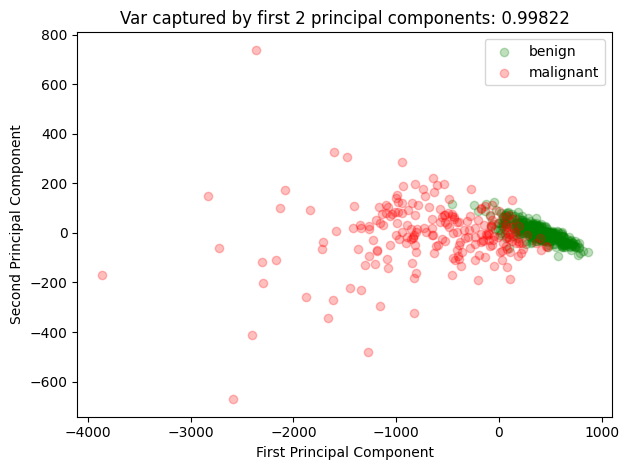

In [ ]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal
    components in the graph title."""
    # load in data
    cancer = sklearn.datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target # Class labels (0 or 1)

    # compute truncated SVD of centered
    mu = X.mean(axis=0)
    Y = X - mu
    U, s, Vh = la.svd(Y, full_matrices=False)
    V = Vh.T

    # compute variance captured by the first 2 principal components
    var = (s[0]**2 + s[1]**2)/sum(s**2)

    Y_hat = Y @ V[:,:2]
    benign = Y_hat[y == 1]
    malignant = Y_hat[y == 0]

    # plot
    plt.scatter(benign[:, 0], benign[:, 1], label='benign', c='green', alpha=0.25)
    plt.scatter(malignant[:, 0], malignant[:, 1], label='malignant', c='red', alpha=0.25)
    plt.title(f'Var captured by first 2 principal components: {round(var,5)}')
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return
prob1()

## Problem 2
Implement the function similar()

In [ ]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components
    of a document and returns two indices: the index of the document
    that is least similar and the index of the document that is most
    similar to i.

    Parameters:
        i: index of a document
        Xhat: decomposed data

    Returns:
        index_min: index of the document least similar to document i
        index_max: index of the document most similar to document i
    """
    # compute the similarity between the ith doc & all other docs
    document = Xhat[i]
    sims = np.dot(Xhat, document)/(la.norm(Xhat, axis=1)*la.norm(document))
    idxmin = np.argmin(sims)

    # find the ind of the doc most similar to the ith doc
    idxmax = np.argsort(sims)[-2]

    return idxmin, idxmax

In [ ]:
# Test case
X = np.array([
    [0.78, 0.14, 0.12, 0.  ],
    [0.64, 0.97, 0.  , 0.  ],
    [0.  , 0.  , 0.63, 0.46],
    [0.  , 0.84, 0.6 , 0.  ],
    [0.29, 0.89, 0.51, 0.  ],
    [0.77, 0.  , 0.27, 0.2 ],
    [0.86, 0.47, 0.  , 0.06],
    [0.89, 0.  , 0.  , 0.  ]
])
print(similar(4, X))

(7, 3)


### Function for Problem 3

In [ ]:
def document_converter():
    """
    Converts speech documents into an n by m array where m is the number
    of vocabulary words and n is the number of documents.

    Returns:
        X ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = sorted([folder+p for p in os.listdir(folder) if p.endswith(".txt")])

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_array((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [ ]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7
    principal components to find the most similar and least similar
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    # run doc converter
    X, paths = document_converter()

    # run svd
    U, s, Vh = spla.svds(X, k=l, random_state=28)
    V = Vh.T
    Xhat = X @ V[:, :l]

    # find the index of the doc most similar to the ith document
    idxmin, idxmax = similar(paths.index(speech), Xhat)
    most, least = os.path.splitext(paths[idxmax].split('/')[-1])[0], os.path.splitext(paths[idxmin].split('/')[-1])[0]

    return most, least

In [ ]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [ ]:
def weighted_document_converter():
    """
    Converts speech documents into an n by m array where m is the number
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.

    Returns:
        A ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    X, paths = document_converter()

    # Problem 4
    # Calculate global weights
    m = len(paths)
    P = X / X.sum(axis=0)
    g = 1 + np.sum((P*np.log(P + 1))/np.log(m), axis=0)
    A = np.multiply(g, np.log(X.todense() + 1))

    return sparse.csr_matrix(A), paths


In [ ]:
weighted_document_converter()

(<66x13905 sparse matrix of type '<class 'numpy.float64'>'
 	with 78023 stored elements in Compressed Sparse Row format>,
 ['./Addresses/1945-Truman.txt',
  './Addresses/1946-Truman.txt',
  './Addresses/1947-Truman.txt',
  './Addresses/1948-Truman.txt',
  './Addresses/1949-Truman.txt',
  './Addresses/1950-Truman.txt',
  './Addresses/1951-Truman.txt',
  './Addresses/1953-Eisenhower.txt',
  './Addresses/1955-Eisenhower.txt',
  './Addresses/1956-Eisenhower.txt',
  './Addresses/1957-Eisenhower.txt',
  './Addresses/1958-Eisenhower.txt',
  './Addresses/1959-Eisenhower.txt',
  './Addresses/1960-Eisenhower.txt',
  './Addresses/1961-Kennedy.txt',
  './Addresses/1962-Kennedy.txt',
  './Addresses/1963-Johnson.txt',
  './Addresses/1963-Kennedy.txt',
  './Addresses/1964-Johnson.txt',
  './Addresses/1965-Johnson-1.txt',
  './Addresses/1965-Johnson-2.txt',
  './Addresses/1966-Johnson.txt',
  './Addresses/1967-Johnson.txt',
  './Addresses/1968-Johnson.txt',
  './Addresses/1969-Johnson.txt',
  './Addre

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [ ]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with
    the first 7 principal components to find the most similar and least
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    # create the PCA transformer w/ hyperparameters
    pca = TruncatedSVD(n_components=l, random_state=74)
    X, paths = weighted_document_converter()
    X = X.toarray()
    Xhat = pca.fit_transform(X)

    # find the index of the doc most similar to the ith document
    idxmin, idxmax = similar(paths.index(speech), Xhat)
    #most, least = os.path.splitext(paths[idxmax].split('/')[-1])[0], os.path.splitext(paths[idxmin].split('/')[-1])[0]
    most, least = os.path.splitext(paths[idxmax].split('/')[-1])[0], os.path.splitext(paths[idxmin].split('/')[-1])[0]

    return most, least

In [ ]:
# Run this box after you have completed prob5()
speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

('1992-Bush', '1946-Truman')
('1985-Reagan', '1946-Truman')


A weird thing happened where my code for the last three problems worked on colab but not in my vscode, so i ran it in colab and saved the run notebook here. (i could not for the life of me figure out what kept going wrong)

## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [3]:
# load & split data
cancer = datasets.load_breast_cancer()
X, y = cancer.data, cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Fit the esimator to training data and predict the test labels.
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# RandomForestClassifier
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

print("KNeighborsClassifier Classification:")
print(classification_report(y_test, knn_predicted))
print("RandomForestClassifier Classification:")
print(classification_report(y_test, rf_predicted))

KNeighborsClassifier Classification:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        45
           1       0.93      0.90      0.91        69

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.90      0.89      0.90       114

RandomForestClassifier Classification:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.97      0.94      0.96        69

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114



Random forest is likely performing better than KNN because it's better at prioritizing avoiding false negatives, so recall is prioritized over precision.

## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [4]:
# load & split data
cancer = datasets.load_breast_cancer()
X, y = cancer.data, cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# RandomForestClassifier
rf = RandomForestClassifier(random_state=2)

# modify three parameters in our grid and use scoring="f1"
param_grid = {"n_estimators": [10, 25, 50, 500],
            "max_depth": [2, 5, 10, 20, 50, 100],
            "min_samples_split": [2, 3, 4, 5, 6]}

# create & train the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# find the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_score}")

# predict w/ the best model
best_model = grid_search.best_estimator_
best_y_pred = best_model.predict(X_test)

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, best_y_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 50}
Best F1 Score: 0.9707829676493022
Confusion Matrix:

[[43  2]
 [ 4 65]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least 0.96

In [6]:
# construct pipeline
pipeline = Pipeline([ ('scaler', StandardScaler()),
                      ('pca', PCA()),
                      ('knn', KNeighborsClassifier())])

# construct parameter grid
param_grid = {  'pca__n_components': [5, 10, 15, 30],
                'knn__n_neighbors': [3, 5, 7, 9],
                'knn__weights': ['uniform', 'distance'],
                'knn__algorithm': ['auto', 'ball_tree', 'kd_tree'],
                'knn__leaf_size': [20, 30, 40],
                'knn__p': [1, 2]}

# construct grid search obj & fit
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# find the best parameters & score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print
print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_score}")

# check via test set to check if we have an F1 score >= 0.96
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)

print(f"Test F1 Score: {test_f1}")


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Parameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 20, 'knn__n_neighbors': 9, 'knn__p': 2, 'knn__weights': 'uniform', 'pca__n_components': 30}
Best F1 Score: 0.9760951199703907
Test F1 Score: 0.9787234042553191
